# Лабораторная работа №3

## Задание:

Выполнить реализацию SGD функции из ЛР1 с помощью Numba и сравнить результаты 

## Функция Бута

$$f(x,y) = (x+2y-7)^2+(2x+y-5)^2$$

In [1]:
from typing import Tuple, Mapping

import numpy as np
import random
from matplotlib import pyplot as plt
import sklearn as skl
from sklearn import datasets
from IPython import display

In [2]:
def Booth (x: np.float32, y: np.float32) -> np.float64:
    return np.square(x+2*y-7)+np.square(2*x+y-5)

def Booth_Grad(x: np.ndarray, y: np.ndarray) -> np.float64:
    return np.array([(10*x+8*y-34), (8*x+10*y-38)])

print('f(1, 3)=0')
print('Booth Result: ', Booth(1,3))
print('Booth Gradient Result: ', Booth_Grad(1,3))

f(1, 3)=0
Booth Result:  0
Booth Gradient Result:  [0 0]


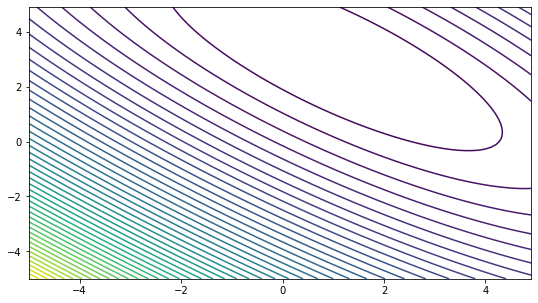

In [3]:
from matplotlib.ticker import MaxNLocator

grid_points = 100
a = b = np.arange(-5.0, 5.0, 0.1)
X, Y = np.meshgrid(a, b)
c = np.array(Booth(np.ravel(X).reshape(a.size**2,1), np.ravel(Y).reshape(a.size**2,1)))
Z = c.reshape(X.shape)

levelsf = MaxNLocator(nbins=100).tick_values(Z.min(), Z.max())
levels = MaxNLocator(nbins=20).tick_values(Z.min(), Z.max())

fig, ax = plt.subplots(figsize=(9,5))
cs = ax.contour(X, Y, Z, 50)
    
plt.show()

## SGD из ЛР1 

In [4]:
def GD(f: Mapping, df: Mapping, x0: np.ndarray, y0: np.ndarray, lr: float = 0.01,
          T: int = 100) -> Tuple [np.ndarray, np.ndarray, np.float32]:
   
    x_old = x0;
    y_old = y0;
    for i in range(T):
        n=df(x0, y0)
        x_new = x_old - lr*n[0]
        y_new = y_old - lr*n[1]
        
    return x_new, y_new, f(x_new, y_new)

In [5]:
z, y = skl.datasets.make_blobs(n_samples=40000, centers=2, n_features=2, random_state=0)
y = np.zeros(40000)
x = np.zeros(40000)
for i in range(len(z)):
    x[i],y[i] = z[i];
print('X: ', x)
print('Y: ', y)

X:  [ 1.58107779  2.02139889  1.74902357 ...  3.58479452 -0.5316157
  2.63024066]
Y:  [-0.21815247  0.41577863  1.10999246 ...  0.55144109  4.041054
 -0.3872784 ]


In [6]:
result = GD(Booth, Booth_Grad, x, y)
print('X: ', result[0])
print('Y: ', result[1])
print('Booth Result: ', result[2])

X:  [ 1.78042221  2.12599671  1.82532181 ...  3.52219978 -0.46173845
  2.73819887]
Y:  [ 0.05717655  0.59248886  1.23907133 ...  0.58951342  4.05947785
 -0.17896981]
Booth Result:  [27.97318504 13.63309541  7.28346668 ... 12.22185665  3.90642696
 21.43046801]


## SGD Numba 

In [7]:
import numba
from numba import jit

In [8]:
@numba.njit(fastmath=True)
def Booth_GPU (x: np.float32, y: np.float32) -> np.float64:
    return np.square(x+2*y-7)+np.square(2*x+y-5)

@numba.njit(fastmath=True)
def Booth_Grad_GPU_1(x: np.float32, y: np.float32) -> np.float64:
    return (10*x+8*y-34)

@numba.njit(fastmath=True)
def Booth_Grad_GPU_2(x: np.float32, y: np.float32) -> np.float64:
    return (8*x+10*y-38)

In [9]:
print('f(1, 3)=0')
print('Booth Result: ', Booth_GPU(1,3))

f(1, 3)=0
Booth Result:  0


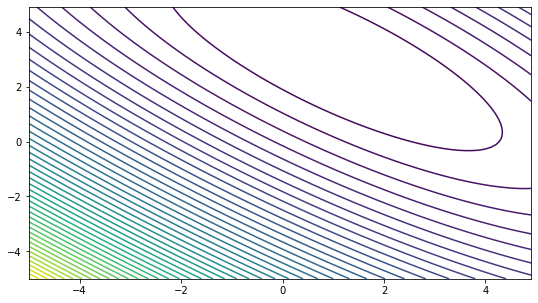

In [10]:
grid_points = 100
a = b = np.arange(-5.0, 5.0, 0.1)
X, Y = np.meshgrid(a, b)
c = np.array(Booth_GPU(np.ravel(X).reshape(a.size**2,1), np.ravel(Y).reshape(a.size**2,1)))
Z = c.reshape(X.shape)

levelsf = MaxNLocator(nbins=100).tick_values(Z.min(), Z.max())
levels = MaxNLocator(nbins=20).tick_values(Z.min(), Z.max())

fig, ax = plt.subplots(figsize=(9,5))
cs = ax.contour(X, Y, Z, 50)
    
plt.show()

In [11]:
@numba.njit(fastmath=True, debug=True)
def GD_GPU(f: Mapping, df1: Mapping, df2: Mapping, x0: np.ndarray, y0: np.ndarray, lr: float = 0.01,
          T: int = 100) -> np.ndarray:
    
    x_old = x0;
    y_old = y0;
    for i in range(T):
        n1=df1(x0, y0)
        n2=df2(x0, y0)
        x_new = x_old - lr*n1
        y_new = y_old - lr*n2
        
    return f(x_new, y_new)

In [12]:
result_GPU = GD_GPU(Booth_GPU, Booth_Grad_GPU_1, Booth_Grad_GPU_2, x, y)
print('X: ', x[0])
print('Y: ', y)
print('Booth Result: ', result_GPU[0])

X:  1.5810777938115395
Y:  [-0.21815247  0.41577863  1.10999246 ...  0.55144109  4.041054
 -0.3872784 ]
Booth Result:  27.97318504199062


## Сравнение по времени 

In [13]:
import IPython

In [14]:
%timeit -n100 GD(Booth, Booth_Grad, x, y) #numpy

20.9 ms ± 31.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%timeit -n100 GD_GPU(Booth_GPU, Booth_Grad_GPU_1, Booth_Grad_GPU_2, x, y) #numba

22.8 ms ± 13.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
